In [1]:
from db_utils import RDSDatabaseConnector, DataTransform, DataFrameInfo, Plotter, DataFrameTransform as dft, get_credentials

import pandas as pd
import yaml
from matplotlib import pyplot as plt
from sqlalchemy import create_engine

from scipy.stats import yeojohnson

creds = get_credentials('credentials.yaml')
RDSDBConn = RDSDatabaseConnector(creds)
engine = RDSDBConn.create_conn()
df = RDSDBConn.get_dataframe(engine)
# RDSDBConn.save_to_file(df)

In [2]:
dfInfo = DataFrameInfo()
dfInfo.describe(df)
dfInfo.get_stats(df)
dfInfo.count_distinct(df)
dfInfo.print_shape(df)
dfInfo.count_null(df)

Column 'member_id' has data type int64
Column 'loan_amount' has data type int64
Column 'funded_amount' has data type float64
Column 'funded_amount_inv' has data type float64
Column 'term' has data type object
Column 'int_rate' has data type float64
Column 'instalment' has data type float64
Column 'grade' has data type object
Column 'sub_grade' has data type object
Column 'employment_length' has data type object
Column 'home_ownership' has data type object
Column 'annual_inc' has data type float64
Column 'verification_status' has data type object
Column 'issue_date' has data type object
Column 'loan_status' has data type object
Column 'payment_plan' has data type object
Column 'purpose' has data type object
Column 'dti' has data type float64
Column 'delinq_2yrs' has data type int64
Column 'earliest_credit_line' has data type object
Column 'inq_last_6mths' has data type int64
Column 'mths_since_last_delinq' has data type float64
Column 'mths_since_last_record' has data type float64
Colum

In [3]:
# Handling Null Values
# Dropping columns. Personally, would keep 'next_payment_date', but Project
# instructions require there to be no null values at the end
df = df.drop(['mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog', 'next_payment_date'], axis=1)
# Imputation
df = dft.drop_null_rows(df, ['last_payment_date', 'last_credit_pull_date', 'collections_12_mths_ex_med'])
df = dft.impute_with_mode(df, 'term')
df = dft.impute_with_mode(df, 'employment_length')
df = dft.impute_with_mean(df, 'funded_amount')
df = dft.impute_with_mean(df, 'int_rate')

# Verify that no more null values are required
dfInfo.describe(df)
dfInfo.get_stats(df)
dfInfo.count_distinct(df)
dfInfo.print_shape(df)
dfInfo.count_null(df)

Column 'member_id' has data type int64
Column 'loan_amount' has data type int64
Column 'funded_amount' has data type float64
Column 'funded_amount_inv' has data type float64
Column 'term' has data type object
Column 'int_rate' has data type float64
Column 'instalment' has data type float64
Column 'grade' has data type object
Column 'sub_grade' has data type object
Column 'employment_length' has data type object
Column 'home_ownership' has data type object
Column 'annual_inc' has data type float64
Column 'verification_status' has data type object
Column 'issue_date' has data type object
Column 'loan_status' has data type object
Column 'payment_plan' has data type object
Column 'purpose' has data type object
Column 'dti' has data type float64
Column 'delinq_2yrs' has data type int64
Column 'earliest_credit_line' has data type object
Column 'inq_last_6mths' has data type int64
Column 'open_accounts' has data type int64
Column 'total_accounts' has data type int64
Column 'out_prncp' has dat

In [4]:
for column in df:
    if df[column].dtype != 'object' and column != 'member_id':
        print(f"Skew of {column} is {df[column].skew()}")

Skew of loan_amount is 0.8043121863503576
Skew of funded_amount is 0.8445441222180953
Skew of funded_amount_inv is 0.8142509295608985
Skew of int_rate is 0.4326861949190135
Skew of instalment is 0.9961503404396858
Skew of annual_inc is 8.73573692583551
Skew of dti is 0.18901977139121579
Skew of delinq_2yrs is 5.318817917464191
Skew of inq_last_6mths is 3.243836167526465
Skew of open_accounts is 1.0594931166880517
Skew of total_accounts is 0.7800832932375489
Skew of out_prncp is 2.352525970614482
Skew of out_prncp_inv is 2.3529464346145614
Skew of total_payment is 1.2692662197762663
Skew of total_payment_inv is 1.2584742300393752
Skew of total_rec_prncp is 1.262007269838639
Skew of total_rec_int is 2.203625284669197
Skew of total_rec_late_fee is 13.258471830549329
Skew of recoveries is 14.382675406825468
Skew of collection_recovery_fee is 27.794716127396722
Skew of last_payment_amount is 2.496078600255455
Skew of collections_12_mths_ex_med is 20.29806369008403
Skew of policy_code is 0.0

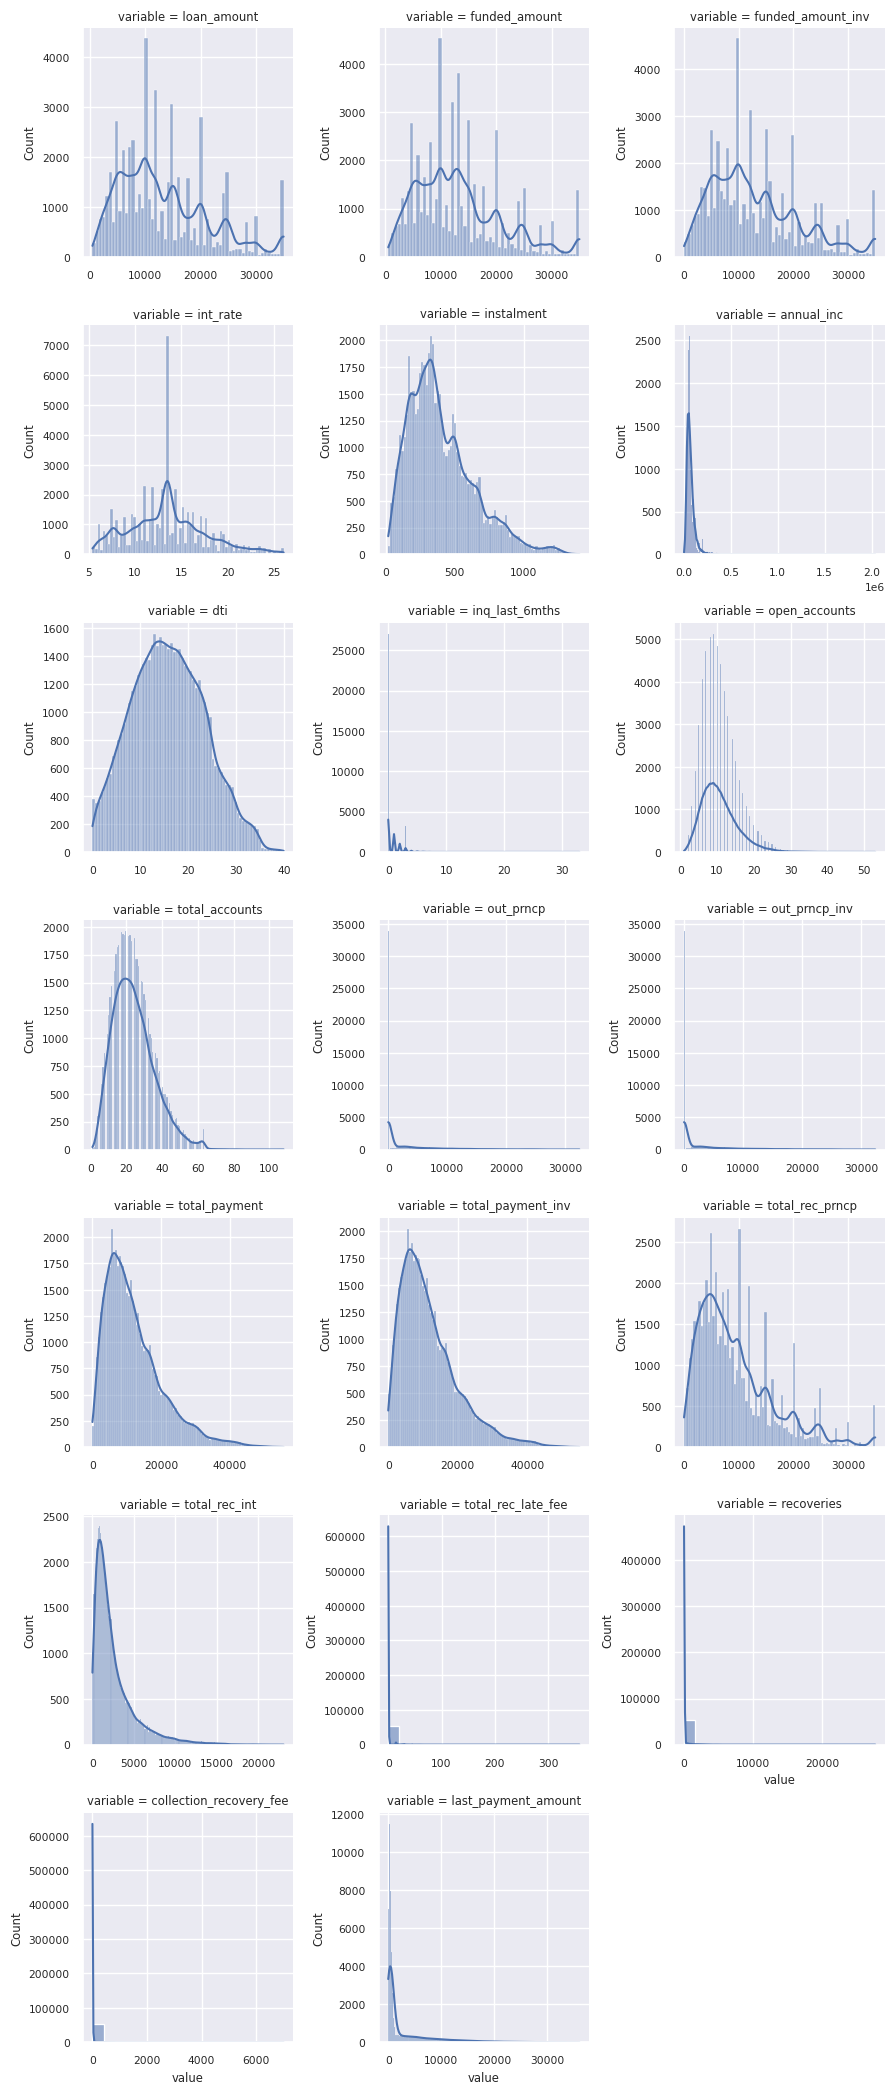

In [5]:
numeric_columns = [
    'loan_amount',
    'funded_amount',
    'funded_amount_inv',
    'int_rate',
    'instalment',
    'annual_inc',
    'dti',
    'inq_last_6mths',
    'open_accounts',
    'total_accounts',
    'out_prncp',
    'out_prncp_inv',
    'total_payment',
    'total_payment_inv',
    'total_rec_prncp',
    'total_rec_int',
    'total_rec_late_fee',
    'recoveries',
    'collection_recovery_fee',
    'last_payment_amount'
]

Plotter.show_all_skews(df, numeric_columns)

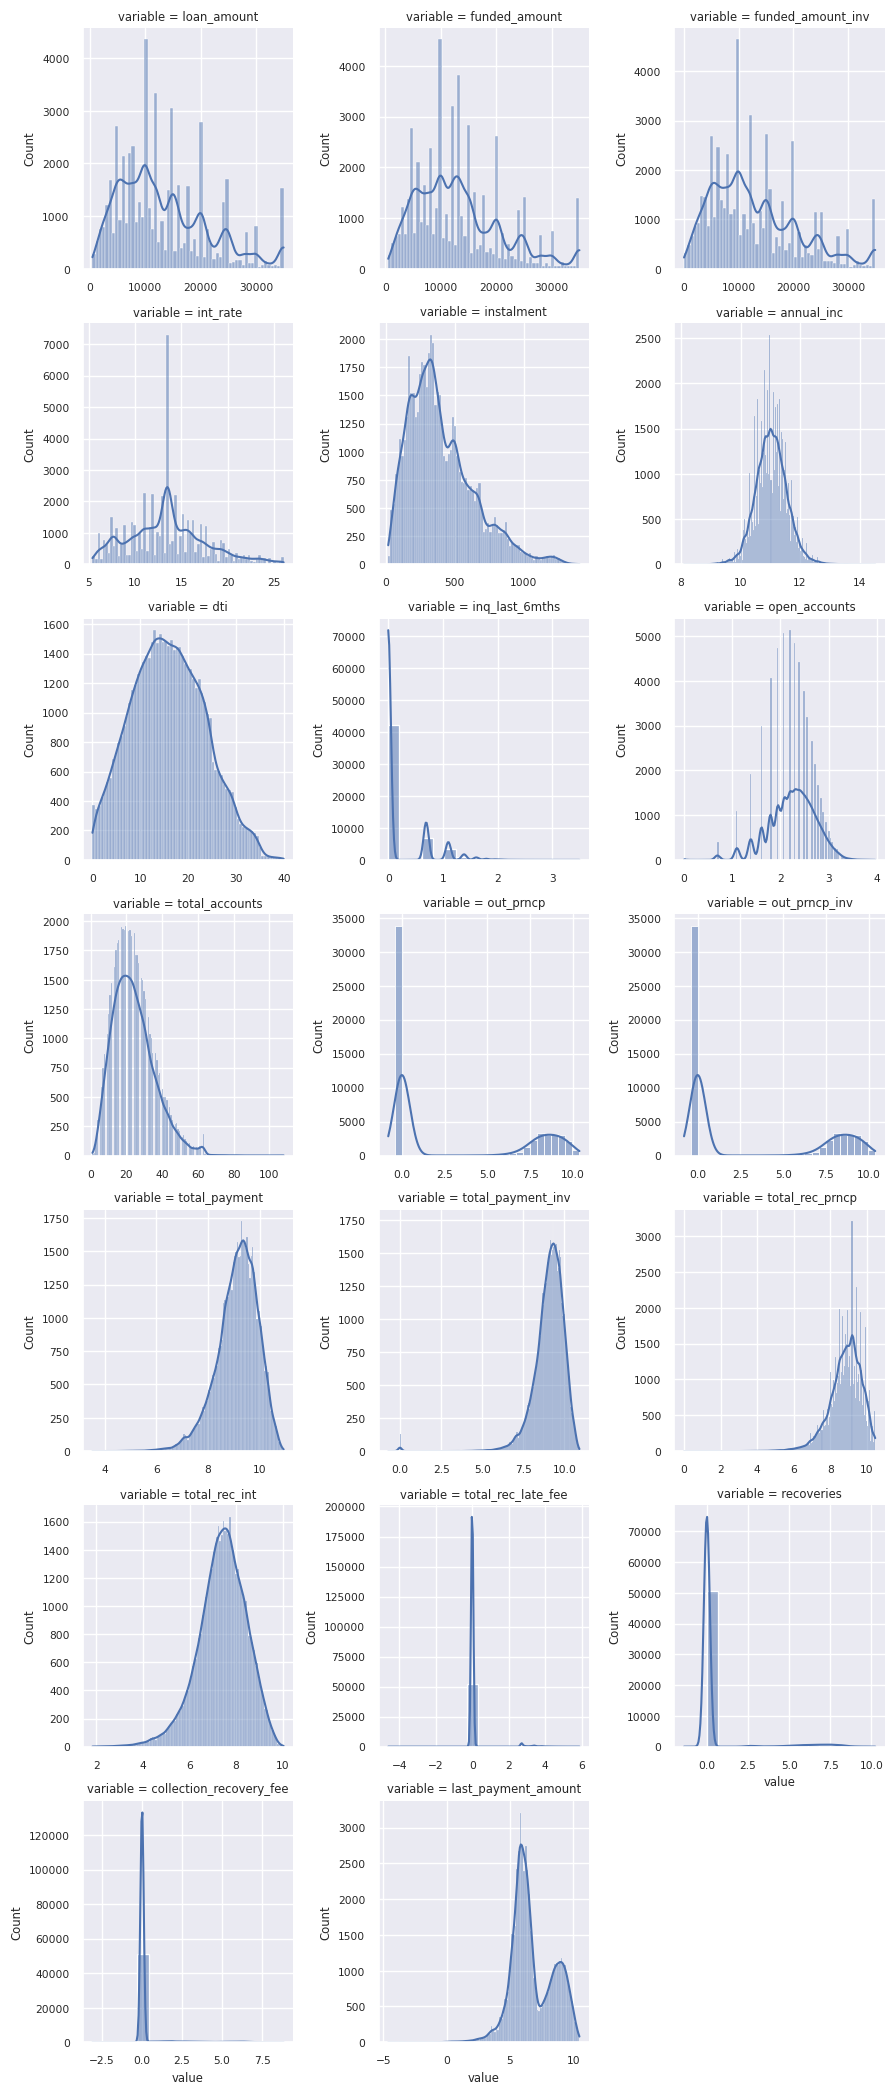

In [6]:
for c in numeric_columns:
    col_skew = df[c].skew()
    if col_skew > 1 or col_skew < -1:
        df[c] = dft.log_transform(df, c)

Plotter.show_all_skews(df, numeric_columns)

In [7]:
# Have to use statistical methods, as generating plots takes an indefinite amount of time
analysis_df = dfInfo.get_z_score(df, 'total_payment')

dfInfo.get_interquartile_range(analysis_df, 'total_payment')



Q1 (25th percentile): 8.685417071770317
Q3 (75th percentile): 9.698293042762764
IQR: 1.0128759709924466
Outliers:
          total_payment  z_scores
id                               
38656111       6.817393 -2.955991
38656004       6.657793 -3.159115
38655850       6.319220 -3.590019
38655738       6.916675 -2.829634
38645937       5.644669 -4.448524
...                 ...       ...
134737         6.273801 -3.647824
131732         7.046508 -2.664395
56413          7.116313 -2.575554
128914         6.407804 -3.477278
55521          7.096523 -2.600741

[1021 rows x 2 columns]


/home/will/exploratory-data-analysis---customer-loans-in-finance521/db_utils.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['z_scores'] = col_z_scores
